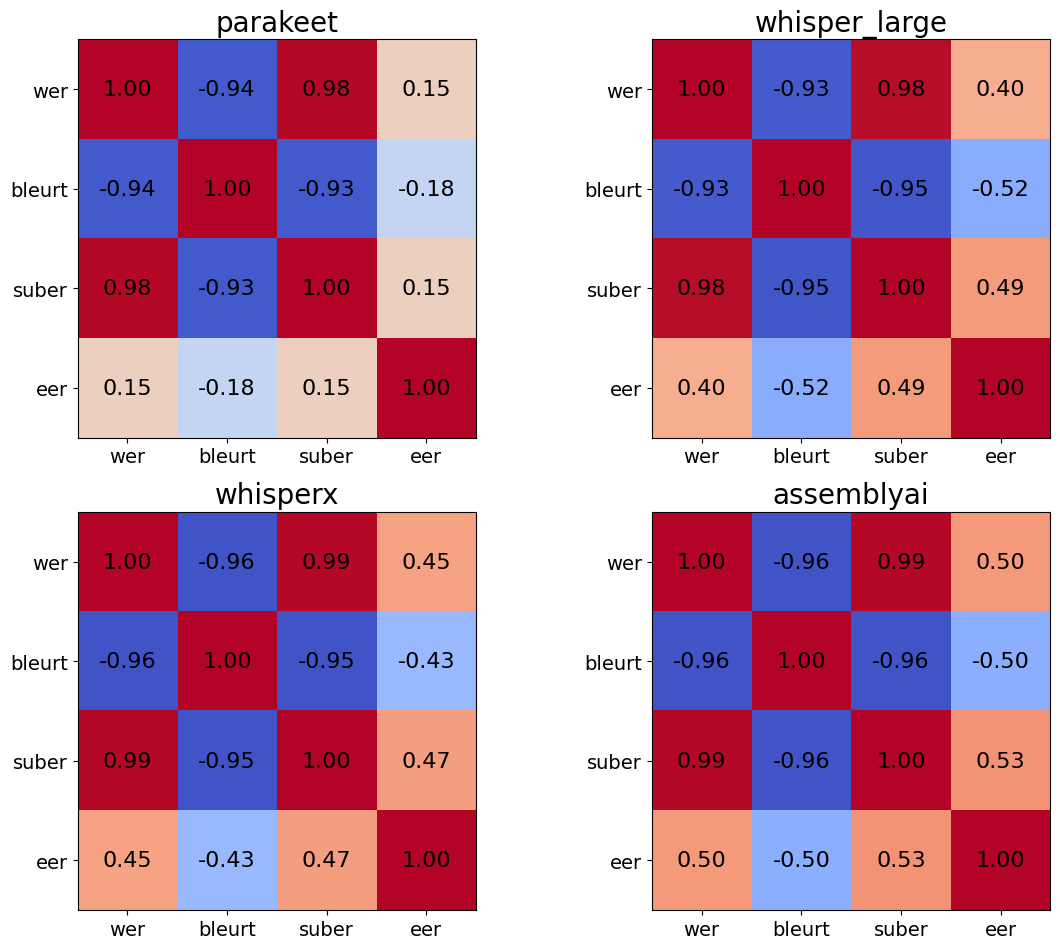

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carica i tre CSV
wer_df    = pd.read_csv("raw_results/wer_results.csv")
bleurt_df = pd.read_csv("raw_results/bleurt_results.csv")
suber_df = pd.read_csv("raw_results/suber_results.csv")
eer_df    = pd.read_csv("raw_results/entity_error_rate.csv")

# Funzione per aggiungere suffisso della metrica
def add_suffix(df, suffix):
    df = df.copy()
    for col in ["parakeet", "whisper_large", "whisperx", "assemblyai"]:
        df[col + "_" + suffix] = df[col]
    return df[["Programma", "Data", "Tipologia"] + [c + "_" + suffix for c in ["parakeet","whisper_large","whisperx","assemblyai"]]]

wer_df    = add_suffix(wer_df, "wer")
bleurt_df = add_suffix(bleurt_df, "bleurt")
suber_df = add_suffix(suber_df, "suber")
eer_df    = add_suffix(eer_df, "eer")

# Merge dei tre dataframe
merged = wer_df.merge(bleurt_df, on=["Programma", "Data", "Tipologia"])
merged = merged.merge(suber_df, on=["Programma", "Data", "Tipologia"])
merged = merged.merge(eer_df, on=["Programma", "Data", "Tipologia"])

# --- Calcolo correlazioni aggregate ---
results = []
for model in ["parakeet", "whisper_large", "whisperx", "assemblyai"]:
    corr_df = merged[[f"{model}_wer", f"{model}_bleurt", f"{model}_suber", f"{model}_eer"]].corr()

    results.append({
        "Modello": model,
        "corr(wer, bleurt)": corr_df.loc[f"{model}_wer", f"{model}_bleurt"],
        "corr(wer, eer)": corr_df.loc[f"{model}_wer", f"{model}_eer"],
        "corr(wer, suber)": corr_df.loc[f"{model}_wer", f"{model}_suber"],
        "corr(bleurt, suber)": corr_df.loc[f"{model}_bleurt", f"{model}_suber"],            
        "corr(bleurt, eer)": corr_df.loc[f"{model}_bleurt", f"{model}_eer"],
        "corr(eer, suber)": corr_df.loc[f"{model}_eer", f"{model}_suber"],
    })

correlation_df = pd.DataFrame(results)

# --- Corrplot (heatmap delle correlazioni) ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
#fig.suptitle("Correlation between metrics", fontsize=18)

for i, model in enumerate(["parakeet", "whisper_large", "whisperx", "assemblyai"]):
    ax = axes[i // 2, i % 2]
    corr = merged[[f"{model}_wer", f"{model}_bleurt", f"{model}_suber", f"{model}_eer"]].corr()

    im = ax.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
    ax.set_title(model, fontsize=20)
    ax.set_xticks(range(len(corr.columns)))
    ax.set_yticks(range(len(corr.columns)))
    ax.set_xticklabels(["wer", "bleurt", "suber", "eer"], fontsize=14)
    ax.set_yticklabels(["wer", "bleurt", "suber", "eer"], fontsize=14)
    for (j, k), val in np.ndenumerate(corr.values):
        ax.text(k, j, f"{val:.2f}", ha="center", va="center", color="black", fontsize=16)

#fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.tight_layout(rect=[0, 0, 1, 0.96])
